In [1]:
!pip install git+https://github.com/business-science/pymodeltime.git


  Cloning https://github.com/business-science/pymodeltime.git to /tmp/pip-req-build-ln_qli9q
  Running command git clone --filter=blob:none --quiet https://github.com/business-science/pymodeltime.git /tmp/pip-req-build-ln_qli9q
  Resolved https://github.com/business-science/pymodeltime.git to commit 6d5be52698fed75bb2f197dd9a98370f4a803c7d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.2/265.2 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.1/229.1 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.0/306.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.7/416.7 kB 37.2 MB/s eta 0:00:00
     ━━━

In [11]:
from pymodeltime import ArimaReg, ProphetReg
from pymodeltime import ModelTimeTable, ModelTimeAccuracy, ModelTimeCalibration, ModelTimeForecast,ModelTimeRefit
from pymodeltime import ArimaReg, ProphetReg
from pymodeltime import MLModelWrapper,H2OAutoMLWrapper
from pymodeltime import plot_modeltime_forecast
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

import logging

# Set logging level to WARNING to suppress DEBUG and INFO messages
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)


In [8]:
import pandas as pd

url = 'https://raw.githubusercontent.com/business-science/pymodeltime/main/data/m750.csv'
data = pd.read_csv(url)

# Display the first few rows of the DataFrame
print(data.head())


     id        date  value
0  M750  1990-05-01   6620
1  M750  1990-06-01   6690
2  M750  1990-07-01   6000
3  M750  1990-08-01   5450
4  M750  1990-09-01   6480


In [9]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

In [12]:
# Initialize and fit the ARIMA model
arima_reg_model_uni = ArimaReg(
    non_seasonal_ar=1,
    non_seasonal_differences=0,
    non_seasonal_ma=1,
    seasonal_ar=0,
    seasonal_differences=1,
    seasonal_ma=1,
    seasonal_period=12,trend= 't',uses_date=True
) # (no trend), 'c' (constant), 't' (linear trend), or 'ct' (constant and linear trend).

prophet_model_uni  = ProphetReg(seasonality_yearly=True, seasonality_weekly=True,
                               seasonality_daily=False, changepoint_range=0.5, prior_scale_seasonality=5.0,
                               season='multiplicative',interval_width=0.95 )


arima_reg_model_uni.fit(train_data[['value']], target_column='value')
prophet_model_uni.fit(train_data[['date', 'value']], target_column='value', date_column='date')




# ModelTimeTable

In [13]:
modeltime_table_uni = ModelTimeTable(arima_reg_model_uni,prophet_model_uni)

# ModelTimeCalibration

In [14]:
# Example usage univariate
test_data_uni = test_data[['date','value']]
test_data_uni.dropna(inplace=True)

model_time_calibrator_uni = ModelTimeCalibration(modeltime_table_uni, test_data_uni,target_column = 'value')
model_time_calibrator_uni.calibrate()

calibration_results_df_uni = model_time_calibrator_uni.get_calibration_results()
print(calibration_results_df_uni)




   .model_id    .model              .model_desc   .type  .calibration_data
0          1  <fit[+]>  ARIMA(1,0,1)(0,1,1)[12]  Custom  <tibble [61 × 4]>
1          2  <fit[+]>                  PROPHET  Custom  <tibble [61 × 4]>


# ModelTimeAccuracy

In [15]:
# Example usage


target_column = 'value'  # Replace with your actual target column name
modeltime_accuracy = ModelTimeAccuracy(modeltime_table_uni, test_data_uni, target_column)
accuracy_results = modeltime_accuracy.calculate_accuracy()
print(accuracy_results)

   model_id               model_desc        mae        rmse        r2
0         1  ARIMA(1,0,1)(0,1,1)[12]  572.06390  612.691075 -0.024123
1         2                  PROPHET  203.88089  275.135310  0.793480


# ModelTimeForecast

In [16]:
forecast_test_uni = ModelTimeForecast(modeltime_table_uni, new_data=test_data_uni, actual_data=data,target_column= 'value')
forecast_results_test_uni = forecast_test_uni.forecast()
forecast_results_test_uni.to_csv("forecast_results_uni.csv", index=False)

Processing predictions for model: ArimaReg
Processing predictions for model: ProphetReg
Original columns before processing for Prophet: Index(['date', 'value'], dtype='object')
Columns after processing for Prophet: Index(['ds', 'value'], dtype='object')


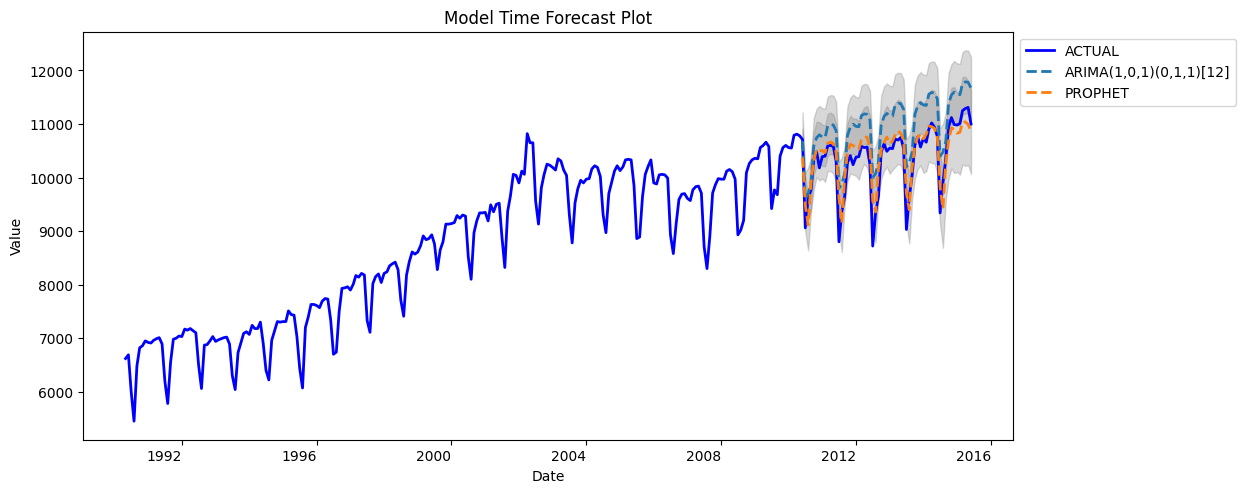

In [17]:

plot_modeltime_forecast(forecast_results_test_uni, interactive=False)  # For static plot
plot_modeltime_forecast(forecast_results_test_uni, interactive=True)   # For interactive plot

# ModelTimeRefit

In [18]:

# Initialize the refitter
refitter = ModelTimeRefit(modeltime_table_uni, verbose=True, parallel=True, max_workers=4)

# Refit the models with the new data
full_data = pd.concat([train_data, test_data], ignore_index=True)  # Replace with your entire dataset (train + test)


target_column = 'value'  # Specify the target column from your dataset
refitted_models = refitter.refit_models(full_data, target_column)


Model successfully refitted: <pymodeltime.ProphetReg.ProphetReg object at 0x7b4abc5eec50>
Model successfully refitted: <pymodeltime.ArimaReg.ArimaReg object at 0x7b4abc5ef100>


In [27]:
from prophet import Prophet
import pandas as pd

from pymodeltime import MLModelWrapper
from pymodeltime import H2OAutoMLWrapper
from pymodeltime import ArimaReg
from pymodeltime import ProphetReg
from pymodeltime import ModelTimeTable
from pymodeltime import AutoGluonTabularWrapper




forecast_horizon = "12 months"

forecast_future = ModelTimeForecast(modeltime_table_uni, actual_data= full_data, forecast_horizon=forecast_horizon,target_column= 'value')
forecast_results_future_uni = forecast_future.forecast()
forecast_results_future_uni.to_csv("forecast_results_future_uni.csv", index=False)


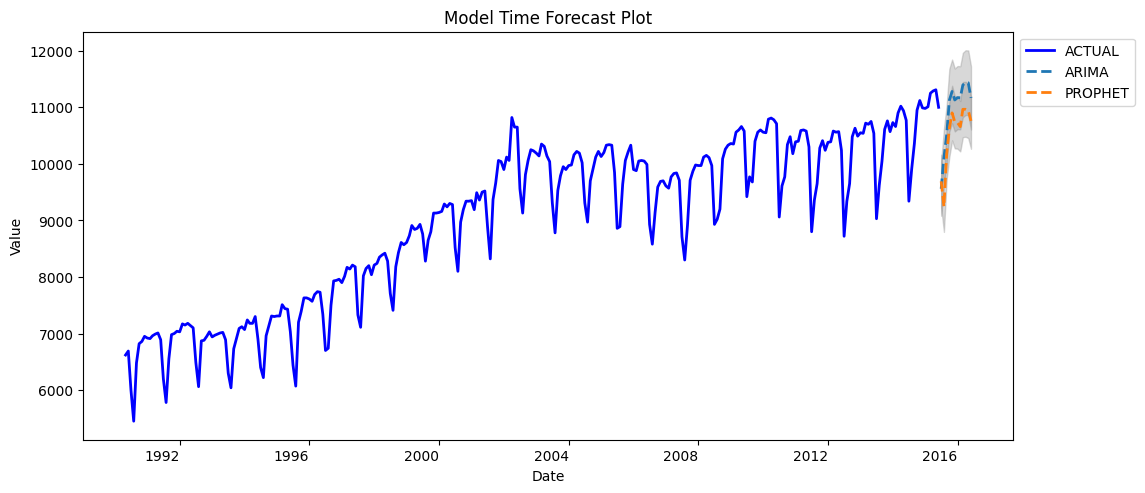

In [25]:

plot_modeltime_forecast(forecast_results_future_uni, interactive=False)  # For static plot
plot_modeltime_forecast(forecast_results_future_uni, interactive=True)   # For interactive plot